In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

In [2]:
def gather_fortran_data_column_sum(path, total_ranks, cn, var):
    """Gather Fortran diagnostics output
    Assuming the fileout has this format: atmos_custom_fine_inst.tile%RANK.nc
    where %RANK is the tile number starting from 1
    Args:
        path: direcotry to Fortran output files
        total_ranks: total number of ranks (e.g., 6, 54)
        cn: resolution (e.g., 12, 48)
        var: variable name to be extracted
    """
    ts_size = len(xr.open_dataset(path+"/atmos_custom_fine_inst.tile1.nc")["time"])
    fortran_sum = np.zeros((ts_size, total_ranks, cn, cn))
    lat = np.zeros((6, cn + 1, cn + 1))
    lon = np.zeros((6, cn + 1, cn + 1))
    for rank in range(total_ranks):
        f = xr.open_dataset(path+"/atmos_custom_fine_inst.tile"+str(rank+1)+".nc")
        fortran_sum[:,rank, :, :] = f[var][:,:,:,:].sum(axis=1)
        lat[rank,:,:] = f["latb"]
        lon[rank,:,:] = f["lonb"]
        f.close()
    return lat, lon, fortran_sum

def gather_fortran_data_at_klevel(path, total_ranks, cn, var, klevel):
    """Gather Fortran diagnostics output
    Assuming the fileout has this format: atmos_custom_fine_inst.tile%RANK.nc
    where %RANK is the tile number starting from 1
    Args:
        path: direcotry to Fortran output files
        total_ranks: total number of ranks (e.g., 6, 54)
        cn: resolution (e.g., 12, 48)
        var: variable name to be extracted
        klevel: index number in the k-axis to be read
    """
    ts_size = len(xr.open_dataset(path+"/atmos_custom_fine_inst.tile1.nc")["time"])
    fortran_sum = np.zeros((ts_size, total_ranks, cn, cn))
    lat = np.zeros((6, cn + 1, cn + 1))
    lon = np.zeros((6, cn + 1, cn + 1))
    for rank in range(total_ranks):
        f = xr.open_dataset(path+"/atmos_custom_fine_inst.tile"+str(rank+1)+".nc")
        fortran_sum[:,rank, :, :] = f[var][:,klevel,:,:]
        lat[rank,:,:] = f["latb"]
        lon[rank,:,:] = f["lonb"]
        f.close()
    return lat, lon, fortran_sum

In [3]:
def gather_python_data_column_sum(path, total_ranks, cn, var, ts_list):
    """Gather Python output
    Assuming the fileout has this format: pace_output_t_%TS_rank_%RANK.npy
    where %TS is the number of timesteps since the beginning, %RANK is the tile number starting from 0
    Args:
        path: direcotry to Fortran output files
        total_ranks: total number of ranks (e.g., 6, 54)
        cn: resolution (e.g., 12, 48)
        var: variable name to be extracted
        ts_list: list of timesteps to be read
    """    
    var_sum = np.zeros((len(ts_list),total_ranks, cn, cn))
    t_index = 0
    for ts in ts_list:
        for rank in range(total_ranks):
            f = np.load(path+"/pace_output_t_"+str(ts)+"_rank_"+str(rank)+".npy", allow_pickle=True).item()
            var_sum[t_index, rank, :, :] = f[var][3:-4,3:-4,:].sum(axis=-1).T
        t_index += 1
    return var_sum

def gather_python_data_at_klevel(path, total_ranks, cn, var, klevel, ts_list):
    """Gather Python output
    Assuming the fileout has this format: pace_output_t_%TS_rank_%RANK.npy
    where %TS is the number of timesteps since the beginning, %RANK is the tile number starting from 0
    Args:
        path: direcotry to Fortran output files
        total_ranks: total number of ranks (e.g., 6, 54)
        cn: resolution (e.g., 12, 48)
        var: variable name to be extracted
        klevel: index number in the k-axis to be read
        ts_list: list of timesteps to be read
    """    
    var_sum = np.zeros((len(ts_list),total_ranks, cn, cn))
    t_index = 0
    for ts in ts_list:
        for rank in range(total_ranks):
            f = np.load(path+"/pace_output_t_"+str(ts)+"_rank_"+str(rank)+".npy", allow_pickle=True).item()
            var_sum[t_index, rank, :, :] = f[var][3:-4,3:-4,klevel].T
        t_index += 1
    return var_sum

In [4]:
# Fortran data are stored here: gs://vcm-fv3gfs-data/time_series_data/c12_baroclinic_100steps
path = "/path/to/c12_baroclinic_100steps"
lat, lon, fortran_sum = gather_fortran_data_column_sum(path, 6, 12, "rainwat")
# Python data are generated from dyn_phy.py
path = "/path/to/python/output"
python_sum = gather_python_data_column_sum(path, 6, 12, "qrain", np.arange(5,101,5))

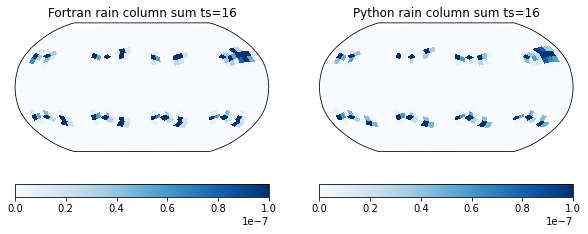

In [5]:
ts = 15
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": ccrs.Robinson()})
vmax = 1e-7 # np.percentile(fortran_sum[ts,:,:,:], 99)
var = "rain"
h = pcolormesh_cube(
    lat,
    lon,
    fortran_sum[ts,:,:,:],
    vmin=0,
    vmax=vmax,
    cmap=plt.cm.Blues,
    ax=ax[0],
    edgecolor=None,
    linewidth=0.01,
)
ax[0].set_title("Fortran "+var+" column sum ts="+str(ts+1))
plt.colorbar(h, ax=ax[0], label="", orientation="horizontal")

h = pcolormesh_cube(
    lat,
    lon,
    python_sum[ts,:,:,:],
    vmin=0,
    vmax=vmax,
    cmap=plt.cm.Blues,
    ax=ax[1],
    edgecolor=None,
    linewidth=0.01,
)
ax[1].set_title("Python "+var+" column sum ts="+str(ts+1))
plt.colorbar(h, ax=ax[1], label="", orientation="horizontal")

fig.set_size_inches([10, 4])
plt.savefig("Comparison_time_step_"+var+"_"+str(ts+1)+".png", dpi=200)

In [6]:
# Fortran data are stored here: gs://vcm-fv3gfs-data/time_series_data/c12_baroclinic_100steps
path = "/path/to/c12_baroclinic_100steps"
klevel = 60
lat, lon, fortran_at_klevel = gather_fortran_data_at_klevel(path, 6, 12, "vcomp", klevel)
# Python data are generated from dyn_phy.py
path = "/path/to/python/output"
python_at_klevel = gather_python_data_at_klevel(path, 6, 12, "va", klevel,  np.arange(5,101,5))

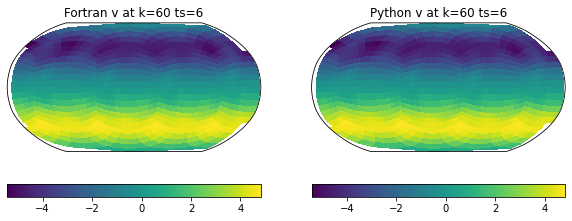

In [7]:
ts = 5
var = "v"
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": ccrs.Robinson()})
vmin = fortran_at_klevel[ts,:,:,:].min()
vmax = fortran_at_klevel[ts,:,:,:].max()
h = pcolormesh_cube(
    lat,
    lon,
    fortran_at_klevel[ts,:,:,:],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.viridis,
    ax=ax[0],
    edgecolor=None,
    linewidth=0.01,
)
ax[0].set_title("Fortran "+var+" at k="+str(klevel)+" ts="+str(ts+1))
plt.colorbar(h, ax=ax[0], label="", orientation="horizontal")

h = pcolormesh_cube(
    lat,
    lon,
    python_at_klevel[ts,:,:,:],
    vmin=vmin,
    vmax=vmax,
    cmap=plt.cm.viridis,
    ax=ax[1],
    edgecolor=None,
    linewidth=0.01,
)
ax[1].set_title("Python "+var+" at k="+str(klevel)+" ts="+str(ts+1))
plt.colorbar(h, ax=ax[1], label="", orientation="horizontal")

fig.set_size_inches([10, 4])

In [8]:
# Fortran data are stored here: gs://vcm-fv3gfs-data/time_series_data/c128_baroclinic_400steps
path = "/path/to/c128_baroclinic_400steps"
lat, lon, fortran_sum = gather_fortran_data_column_sum(path, 6, 128, "rainwat")

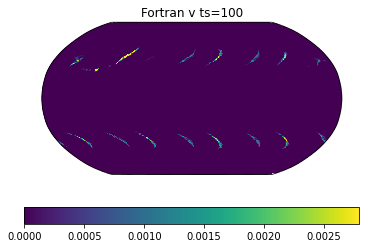

In [9]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.Robinson()})
ts = 99
vmin = fortran_sum[ts,:,:,:].min()
vmax = np.percentile(fortran_sum[ts,:,:,:], 99.9)
h = pcolormesh_cube(
    lat,
    lon,
    fortran_sum[ts,:,:,:],
    vmin=0,
    vmax=vmax,
    cmap=plt.cm.viridis,
    ax=ax,
    edgecolor=None,
    linewidth=0.01,
)
ax.set_title("Fortran "+var+" ts="+str(ts+1))
plt.colorbar(h, ax=ax, label="", orientation="horizontal")